In [276]:
import os
import pickle
import time
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.tools.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_validation import KFold, StratifiedKFold, train_test_split
from sklearn.datasets.base import Bunch
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import LinearSVC, NuSVC, SVC

In [277]:
WINE = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

In [278]:
def download_data(url, path='data'):
    if not os.path.exists(path):
        os.mkdir(path)

    response = requests.get(url)
    name = os.path.basename(url)
    with open(os.path.join(path, name), 'wb') as f:
        f.write(response.content)

In [279]:
download_data(WINE)

In [280]:
wine    = pd.read_csv('data/winequality-white.csv', sep=";")

In [281]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [282]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [283]:
X = wine[[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide",
    "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"
]]
y = wine["quality"]

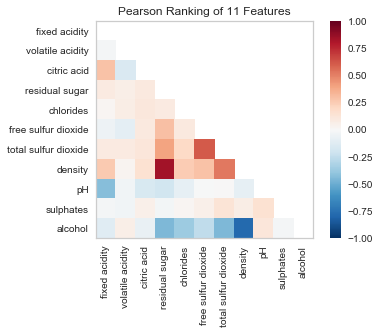

In [284]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X)
visualizer.poof()

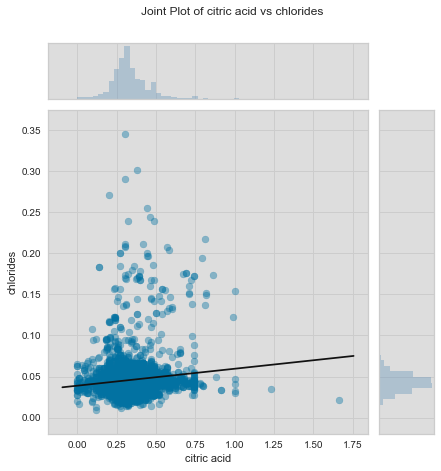

In [285]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='citric acid', target='chlorides')
visualizer.fit(X['citric acid'], X['chlorides'])
visualizer.poof()

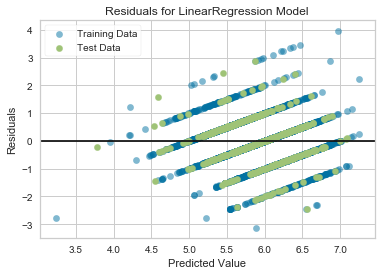

In [286]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1
)

visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

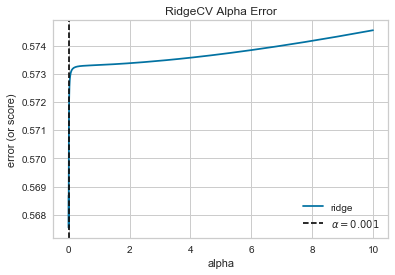

In [287]:
import numpy as np

from sklearn.linear_model import RidgeCV
from yellowbrick.regressor import AlphaSelection

alphas = np.logspace(-10, 1, 200)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X, y)
visualizer.poof()

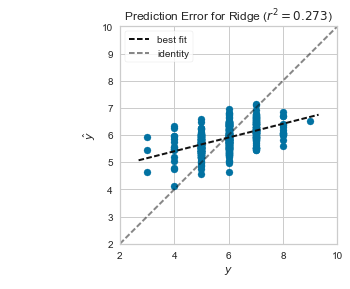

In [288]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(Ridge(alpha=3.181))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [289]:
names = [
    'quality',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol'

]

wine = os.path.join('data','winequality-white.csv')
data   = pd.read_csv(wine, sep=";")
data.columns = names
data.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [290]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9


In [318]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
target   = ['quality']

X = data[features]
y = data[target]

In [319]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())),
         ('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)

    expected  = y
    predicted = model.predict(X)

    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [320]:
# Try them all!
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [317]:
model_selection(X, y, LinearSVC())

ValueError: Target is multiclass but average='binary'. Please choose another average setting.